In [149]:
import pandas as pd
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import numpy as np
import matplotlib as plt
plt.rc('font', family='Malgun Gothic')

In [2]:
# 파일 읽기
sample =pd.read_csv("sample_submission.csv",encoding='cp949') #제출용
profile = pd.read_csv("train_profiles.csv",encoding= 'cp949') #train 나이
test_click = pd.read_csv("test_clickstreams.tab",encoding='cp949',sep = '\t') 
test_search = pd.read_csv("test_searchkeywords.tab",encoding='cp949',sep = '\t')
train_click = pd.read_csv("train_clickstreams.tab",encoding='cp949',sep = '\t')
train_search = pd.read_csv("train_searchkeywords.tab",encoding='cp949',sep = '\t')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# profile GROUP 변수 분리
# **************한 번만 실행해야해요*********************
profile['gender'] = profile.GROUP.apply(lambda x: x[0]) # 성별
profile['age'] = profile.GROUP.apply(lambda x: x[1:]) # 나이
del profile['GROUP'] # GROUP 제거

In [3]:
#null 값 날리기
train_click = train_click.dropna()

In [36]:
#---------------------필요한가?---------------------------------
train_click = pd.merge(train_click,profile) # train_click + profile
train_search = pd.merge(train_search,profile) # train_search + profile
#click = pd.merge(train_click,test_click)  # clicks 통합
#search = pd.merge(train_search, test_search) # search 통합
#--------------------------------------------------------------
#pd.pivot_table(train_click, values='SITE_CNT', index='ACT_NM', columns=['gender','age'], 
#               aggfunc=len, fill_value=0) 
#-----------------------------------------------------------------------------
#del train_click['SITE'] #SITE 변수 삭제

In [9]:
# train_click ['TIME_ID'] 쪼개기
train_click['DATE'] = train_click['TIME_ID'].apply(lambda x : int(str(x)[:8])) # 년월일
#train_click['YEAR'] = train_click['TIME_ID'].apply(lambda x : str(x)[:4]) # 년도
#train_click['MONTH'] = train_click['TIME_ID'].apply(lambda x : str(x)[4:6]) # 월
#train_click['DAY'] = train_click['TIME_ID'].apply(lambda x : str(x)[6:8]) # 일
train_click['HOUR'] = train_click['TIME_ID'].apply(lambda x : int(str(x)[8:])) # 시간

In [37]:
# train_search, test_search 전처리
train_search['QRY_STR']=train_search['QRY_STR']\
.apply(lambda x : x.split('&')[0] if 'acq' in x else x)\
.apply(lambda x : x.split('&')[-1].split('=')[-1] if 'query' in x else x)\
.apply(lambda x : x.replace('+',' '))
test_search['QRY_STR']=test_search['QRY_STR']\
.apply(lambda x : x.split('&')[0] if 'acq' in x else x)\
.apply(lambda x : x.split('&')[-1].split('=')[-1] if 'query' in x else x)\
.apply(lambda x : x.replace('+',' '))

In [73]:
# 단어 분리 개수 세기
M40o = {}
for i in range(len(train_search.query('GROUP=="M40+"').QRY_STR)):
    words = train_search.query('GROUP=="M40+"').QRY_STR.iloc[i]
    for word in words.split(' '):
        try: 
            M40o[word] += 1
        except:
            M40o[word] = 1
    print(i,end='\r')

KeyboardInterrupt: 

In [77]:
# 위에서 만든 사전 values로 정렬
sorted(M40o.items(), key=lambda x: x[1], reverse=True) 

[('메이플스토리', 96),
 ('다시보기', 72),
 ('영화', 48),
 ('사진', 48),
 ('1위', 47),
 ('시청률', 45),
 ('싸이', 42),
 ('스킬트리', 40),
 ('가격', 40),
 ('창원', 39),
 ('옵티머스', 39),
 ('한국', 37),
 ('런던올림픽', 35),
 ('', 34),
 ('올림픽', 33),
 ('아이유', 33),
 ('이혼', 32),
 ('키', 32),
 ('순천', 32),
 ('애니팡', 31),
 ('수지', 30),
 ('??????', 30),
 ('g', 30),
 ('추천', 29),
 ('년', 28),
 ('공개', 28),
 ('결혼', 28),
 ('맛집', 27),
 ('이순신', 26),
 ('뜻', 25),
 ('이미지', 25),
 ('류현진', 25),
 ('선물', 25),
 ('날씨', 25),
 ('일본', 24),
 ('노출', 24),
 ('순위', 24),
 ('강남스타일', 23),
 ('이유', 23),
 ('네이버', 23),
 ('오자룡이간다', 23),
 ('남자', 23),
 ('최고다', 23),
 ('좋은', 23),
 ('영어로', 23),
 ('프로', 23),
 ('부산', 22),
 ('광고', 22),
 ('고백', 22),
 ('방법', 22),
 ('다음', 21),
 ('위치', 21),
 ('내', 20),
 ('허준', 20),
 ('갤럭시', 20),
 ('공식', 20),
 ('로또', 20),
 ('박근혜', 20),
 ('안철수', 20),
 ('서울', 20),
 ('주소', 20),
 ('드라마', 19),
 ('드래곤플라이트', 19),
 ('교대역', 19),
 ('컴퓨터', 18),
 ('여자', 18),
 ('공략', 18),
 ('포토샵', 18),
 ('블루스택', 18),
 ('배', 18),
 ('후쿠오카', 18),
 ('해명', 17),
 ('영어', 17),
 ('뮤비', 1

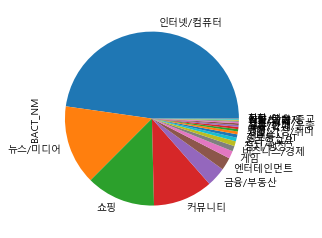

In [150]:
train_click['BACT_NM'].apply(lambda x : str(x)).value_counts().plot.pie()

In [200]:
# 임용고시가 있는 CUS_ID, GROUP 확인
word = train_click['ACT_NM'].str.contains("임용고시")
pd.DataFrame(train_click.query('@word').groupby(['CUS_ID','GROUP']).count().iloc[:,0]).rename(columns={'TIME_ID':'COUNT'})

,,COUNT
CUS_ID,GROUP,
252,F30,2
281,F20-,5
691,M30,4
695,F30,1
812,F30,1
846,F20-,39
958,M30,6
1169,F20-,1
1815,M20-,42


In [7]:
x = train_click[['SITE_CNT','ST_TIME']]
y = train_click['age']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.24, random_state=0)
print(len(X_train) == len(y_train)
,len(X_test) == len(y_test))

In [ ]:
from sklearn.svm import SVC

svm = SVC(kernel='rbf', C=1.0, random_state=0)
# 로지스틱 회귀에서의 C와 반대의 개념. 모델을 조율해주는 값이라고 보면 됨.
svm.fit(X_train, y_train)
y_pred_svc = svm.predict(X_test)
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred_svc))


np.random.seed(0)
X_xor = np.random.randn(200, 2)
y_xor = np.logical_xor(X_xor[:, 0] > 0,
                       X_xor[:, 1] > 0)
y_xor = np.where(y_xor, 1, -1)

plt.scatter(X_xor[y_xor == 1, 0],
            X_xor[y_xor == 1, 1],
            c='b', marker='x',
            label='1')
plt.scatter(X_xor[y_xor == -1, 0],
            X_xor[y_xor == -1, 1],
            c='r',
            marker='s',
            label='-1')

plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.legend(loc='best')
plt.tight_layout()
# plt.savefig('./figures/xor.png', dpi=300)
plt.show()


svm = SVC(kernel='rbf', C=10.0, random_state=0, gamma=0.10)
svm.fit(X_xor, y_xor)
y_pred_ksvc = svm.predict(X_xor)
print('Accuracy: %.2f' % accuracy_score(y_xor, y_pred_ksvc))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
